# Programming and Mathematics for AI: Task 4

# Part 1: Implement a Neural Network (Baseline)

Imports

In [81]:
# NumPy
import numpy as np

# PyTorch - Open-source machine learning framework
import torch
import torch.nn as nn # Neural network
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

#Torchvision - Package consisting of popular datasets, model architectures, and common image transformations for computer vision
import torchvision
# from torchvision import datasets # Possibly remove
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 # Dataset
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Matplotlib - Visualising data
import matplotlib.pyplot as plt
%matplotlib inline


Downloading CIFAR-10 dataset, and examining its contents. 50,000 images are intended for training, and 10,000 for testing.  We will split this further by including a validation set of 5,000 images from the training set.

In [82]:
training_data = CIFAR10(root = 'data/', download = True, transform = ToTensor())

testing_data = CIFAR10(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [83]:
classes = training_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [84]:
training_data_size = len(training_data)
training_data_size

50000

In [85]:
testing_data_size = len(testing_data)
testing_data_size

10000

In [86]:
classes_count = len(training_data.classes)
classes_count

10

In [87]:
# Image shape
image, label = training_data[0]
image_shape = image.shape
image_shape

torch.Size([3, 32, 32])

Further splitting data to get a validation set.  Using a seed value to ensure the same validation set is always used.

In [88]:
# Validation data size
validation_size = 5000
# New training data size
training_size = len(training_data) - validation_size
# Random seed for reproducibility
torch.manual_seed(25)

Using random split on training data to allocate 5,000 images to validation.

In [89]:
training_data, validation_data = random_split(training_data, [training_size, validation_size])

# Final datasets
print(len(training_data)) # Data used to fit the model
print(len(validation_data)) # Data used to fine-tune the model hyperparameters
print(len(testing_data)) # Data used to provide an unbiased evaluation of a final NN

45000
5000
10000


Baseline Parameters

Batch size defines the number of samples that will be propagated through the neural network, number of epochs determines training times, optimiser function has several options.  Learning rate describes the rate at which the model optimises.

In [90]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

Data loaders for training, validation, testing sets.  We used shuffle for the training data loader so that batches are different per epoch during training.  This boosts generalisation. 2 workers are used, as recommended by colab.

In [91]:
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)

testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

# Building the Neural Network

Function to determine model accuracy

In [92]:
def determine_accuracy(outputs, labels):
    """Determine accuracy via predictions"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [93]:
class NeuralNetwork(nn.Module):

    def train_batch(self, batch):
        """Training batch: making predictions and determining loss"""

        batch_images, batch_labels = batch

        # Make predictions
        out = self(batch_images)

        # Determine batch loss
        batch_loss = F.cross_entropy(out, batch_labels)
        return batch_loss
    
    def validate_batch(self, batch):
        """Validating batch: making predictions, determining loss and accuracy"""

        batch_images, batch_labels = batch

        # Make predictions
        out = self(batch_images)

        # Determine loss
        batch_loss = F.cross_entropy(out, batch_labels)

        # Calculate accuracy
        accuracy = determine_accuracy(out, batch_labels)
        return {'validation_loss': batch_loss.detach(), 'validation_accuracy': accuracy}
        
    def validate_epoch(self, outputs):
        """Validate batches at the end of epoch"""

        # Losses across epochs
        epoch_losses = [x['validation_loss'] for x in outputs]

        # Combining losses using mean
        combined_epoch_loss = torch.stack(epoch_losses).mean()

        # Accuracies across epochs
        epoch_accs = [x['validation_accuracy'] for x in outputs]

        # Combining accuracies using mean
        combined_epoch_acc = torch.stack(epoch_accs).mean()

        return {'validation_loss': combined_epoch_loss.item(), 'validation_accuracy': combined_epoch_acc.item()}
    
    def print_epoch(self, epoch, result):
        """Print epoch number, validation loss and accuracy at the end of each epoch"""

        print("Epoch {} | validation_loss: {:.4f} | validation_accuracy: {:.4f}".format(epoch, result['validation_loss'], result['validation_accuracy']))

Function to evaluate model using model's internal functions

In [94]:
def validate_model(model, validation_loader):
    """Model validation"""

    outputs = [model.validate_batch(batch) for batch in validation_loader]
    return model.validate_epoch(outputs)


Function to train model using evaluation function above, and model's internal training functions.

In [95]:
def fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function):
    """Model training and validation"""

    # Model history
    model_history = []

    # Model optimiser
    model_optimiser = optimiser_function(model.parameters(), learning_rate)

    for epoch in range(epochs):

        # Training
        for batch in training_loader:

            loss = model.train_batch(batch)
            loss.backward()

            model_optimiser.step()
            model_optimiser.zero_grad()

        # Validation
        result = validate_model(model, validation_loader)
        model.print_epoch(epoch, result)
        model_history.append(result)

    return model_history

Checking the use of a dedicated GPU: In our case we mostly used CPUs.

In [96]:
def get_device():
    """Use dedicated GPU if available, else use CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [97]:
device = get_device()
print(device)

cpu


In [98]:
def move_to_device(data, device):
    """Move data to GPU/CPU"""
    if isinstance(data, (list,tuple)):
        # Using recursion if required
        return [move_to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)


Function to plot loss across model history.

In [99]:
def plot_losses(history):
    """Plot loss across model history"""

    losses = [x['validation_loss'] for x in history]

    # Plotting using pyplot
    plt.plot(losses, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss against epochs');

Function to plot accuracy across model history.

In [100]:
def plot_accuracies(history):
    """Plot accuracy across model history"""

    accuracies = [x['validation_accuracy'] for x in history]

    # Plotting using pyplot
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy against epochs');

Data Loaders

In [101]:

class DeviceDataLoader():
    """Move data to a device"""

    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
      
    def __len__(self):
        """Batch count"""

        return len(self.data_loader)
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        
        for b in self.data_loader: 
            yield move_to_device(b, self.device)

    

In [102]:
training_loader = DeviceDataLoader(training_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

# Training the Neural Network

In [103]:
# Input and output

input_size = 3*32*32

output_size = 10

In [104]:
class Model_1(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

Move model to device

In [105]:
model = move_to_device(Model_1(), device)

In [106]:
history = [validate_model(model, validation_loader)]
print(history)

[{'validation_loss': 2.304971694946289, 'validation_accuracy': 0.12934282422065735}]


In [107]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.9605 | validation_accuracy: 0.2781
Epoch 1 | validation_loss: 1.7406 | validation_accuracy: 0.3785
Epoch 2 | validation_loss: 1.7545 | validation_accuracy: 0.3676
Epoch 3 | validation_loss: 1.7191 | validation_accuracy: 0.3739
Epoch 4 | validation_loss: 1.6077 | validation_accuracy: 0.4213
Epoch 5 | validation_loss: 1.5913 | validation_accuracy: 0.4380
Epoch 6 | validation_loss: 1.5850 | validation_accuracy: 0.4263
Epoch 7 | validation_loss: 1.6291 | validation_accuracy: 0.4145
Epoch 8 | validation_loss: 1.4978 | validation_accuracy: 0.4650
Epoch 9 | validation_loss: 1.5688 | validation_accuracy: 0.4414


Initial results

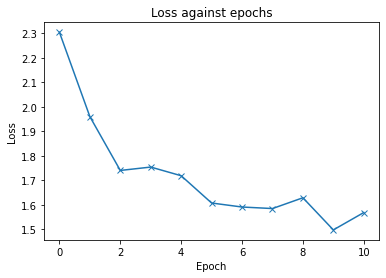

In [108]:
plot_losses(history)

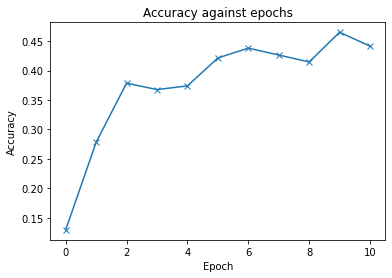

In [109]:
plot_accuracies(history)

In [110]:
learning_rate = 1e-2

In [111]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.4103 | validation_accuracy: 0.4965
Epoch 1 | validation_loss: 1.4036 | validation_accuracy: 0.5026
Epoch 2 | validation_loss: 1.4050 | validation_accuracy: 0.5000
Epoch 3 | validation_loss: 1.3969 | validation_accuracy: 0.4999
Epoch 4 | validation_loss: 1.3950 | validation_accuracy: 0.5037
Epoch 5 | validation_loss: 1.3949 | validation_accuracy: 0.5008
Epoch 6 | validation_loss: 1.3830 | validation_accuracy: 0.5082
Epoch 7 | validation_loss: 1.3925 | validation_accuracy: 0.5030
Epoch 8 | validation_loss: 1.3801 | validation_accuracy: 0.5099
Epoch 9 | validation_loss: 1.3848 | validation_accuracy: 0.5050


In [112]:
learning_rate = 1e-3

In [113]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.3705 | validation_accuracy: 0.5099
Epoch 1 | validation_loss: 1.3735 | validation_accuracy: 0.5075
Epoch 2 | validation_loss: 1.3715 | validation_accuracy: 0.5081
Epoch 3 | validation_loss: 1.3688 | validation_accuracy: 0.5124
Epoch 4 | validation_loss: 1.3769 | validation_accuracy: 0.5063
Epoch 5 | validation_loss: 1.3719 | validation_accuracy: 0.5078
Epoch 6 | validation_loss: 1.3693 | validation_accuracy: 0.5083
Epoch 7 | validation_loss: 1.3687 | validation_accuracy: 0.5110
Epoch 8 | validation_loss: 1.3715 | validation_accuracy: 0.5092
Epoch 9 | validation_loss: 1.3679 | validation_accuracy: 0.5104


Plotting losses across all epochs

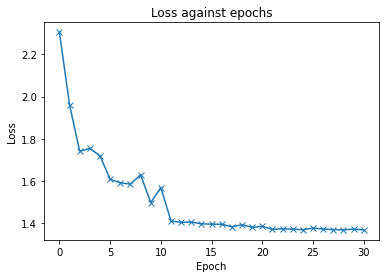

In [114]:
plot_losses(history)

Plotting accuracies across all epochs

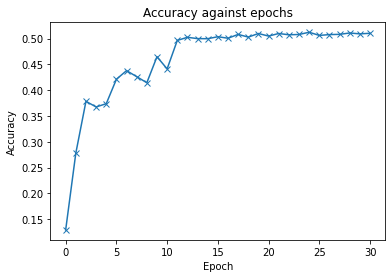

In [115]:
plot_accuracies(history)

Evaluating model using the testing data and validate_model function

In [116]:
validate_model(model, testing_loader)

{'validation_accuracy': 0.5194336175918579,
 'validation_loss': 1.3510839939117432}

In [117]:
# ...

# Part 2: Propose Improvements

# Adding a dropout layer

In [118]:
class Model_dropout(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)

        # Dropout layer: probability set to 0.25
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        # Applying dropout
        x = self.dropout(x)
        x = self.linear3(x)
        
        return x

In [119]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_dropout(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.302995443344116, 'validation_accuracy': 0.0985523909330368}]
Epoch 0 | validation_loss: 1.9705 | validation_accuracy: 0.2702
Epoch 1 | validation_loss: 1.7612 | validation_accuracy: 0.3788
Epoch 2 | validation_loss: 1.7111 | validation_accuracy: 0.3904
Epoch 3 | validation_loss: 1.7071 | validation_accuracy: 0.3907
Epoch 4 | validation_loss: 1.7006 | validation_accuracy: 0.4073
Epoch 5 | validation_loss: 1.6786 | validation_accuracy: 0.3978
Epoch 6 | validation_loss: 1.7054 | validation_accuracy: 0.3989
Epoch 7 | validation_loss: 1.5876 | validation_accuracy: 0.4345
Epoch 8 | validation_loss: 1.5562 | validation_accuracy: 0.4383
Epoch 9 | validation_loss: 1.5456 | validation_accuracy: 0.4413


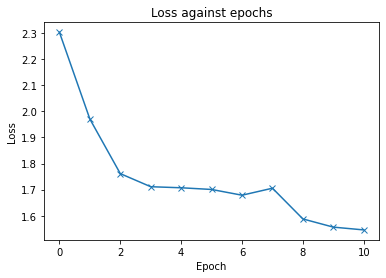

In [120]:
plot_losses(history)

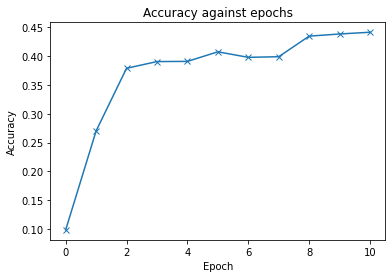

In [121]:
plot_accuracies(history)

Trying a different dropout probability of 0.15:

In [122]:
class Model_dropout(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)

        # Dropout layer: probability set to 0.15
        self.dropout = nn.Dropout(0.15)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        # Applying dropout
        x = self.dropout(x)
        x = self.linear3(x)
        
        return x

In [123]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_dropout(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3033838272094727, 'validation_accuracy': 0.09025735408067703}]
Epoch 0 | validation_loss: 1.8439 | validation_accuracy: 0.3345
Epoch 1 | validation_loss: 1.7454 | validation_accuracy: 0.3809
Epoch 2 | validation_loss: 1.7994 | validation_accuracy: 0.3500
Epoch 3 | validation_loss: 1.7479 | validation_accuracy: 0.3719
Epoch 4 | validation_loss: 1.7138 | validation_accuracy: 0.3911
Epoch 5 | validation_loss: 1.5920 | validation_accuracy: 0.4248
Epoch 6 | validation_loss: 1.6770 | validation_accuracy: 0.4091
Epoch 7 | validation_loss: 1.5560 | validation_accuracy: 0.4479
Epoch 8 | validation_loss: 1.5412 | validation_accuracy: 0.4451
Epoch 9 | validation_loss: 1.5502 | validation_accuracy: 0.4513


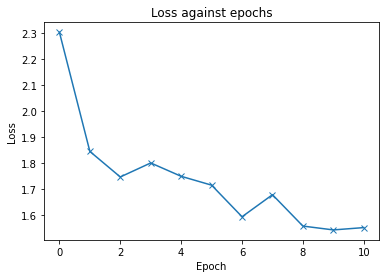

In [124]:
plot_losses(history)

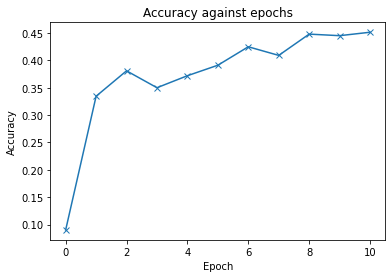

In [125]:
plot_accuracies(history)

# Improvement Attempt: L2 Regularisation

L2 regularisation reduces overfitting by shrinking parameter estimates, which simplifies the model.  This is facilitated via the weight_decay parameter in the optimiser.

In [126]:
# Edited fit_model function to include L2 (weight_decay)

def fit_model_L2(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function, weight_decay):
    """Model training and validation"""

    # Model history
    model_history = []

    # Model optimiser
    model_optimiser = optimiser_function(model.parameters(), learning_rate, weight_decay) # Edited here to include weight_decay

    for epoch in range(epochs):

        # Training
        for batch in training_loader:

            loss = model.train_batch(batch)
            loss.backward()

            model_optimiser.step()
            model_optimiser.zero_grad()

        # Validation
        result = validate_model(model, validation_loader) 
        model.print_epoch(epoch, result)
        model_history.append(result)

    return model_history

Running with weight decay = 1e-5

In [127]:
# Running baseline with weight decay added to optimiser.

weight_decay = 1e-5

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model_L2(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function, weight_decay)

[{'validation_loss': 2.3031325340270996, 'validation_accuracy': 0.10367647558450699}]
Epoch 0 | validation_loss: 1.9492 | validation_accuracy: 0.2964
Epoch 1 | validation_loss: 1.8271 | validation_accuracy: 0.3453
Epoch 2 | validation_loss: 1.7193 | validation_accuracy: 0.3917
Epoch 3 | validation_loss: 1.7616 | validation_accuracy: 0.3801
Epoch 4 | validation_loss: 1.6256 | validation_accuracy: 0.4258
Epoch 5 | validation_loss: 1.5986 | validation_accuracy: 0.4149
Epoch 6 | validation_loss: 1.5407 | validation_accuracy: 0.4458
Epoch 7 | validation_loss: 1.9476 | validation_accuracy: 0.3305
Epoch 8 | validation_loss: 1.5043 | validation_accuracy: 0.4619
Epoch 9 | validation_loss: 1.5885 | validation_accuracy: 0.4366


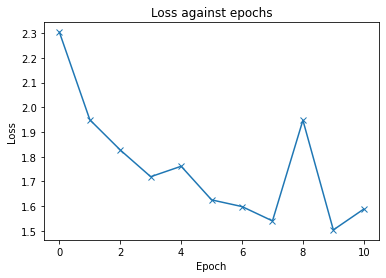

In [128]:
plot_losses(history)

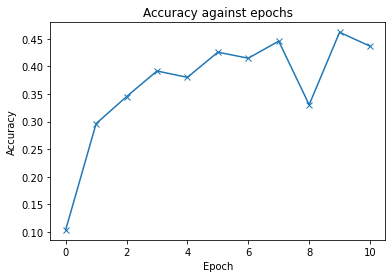

In [129]:
plot_accuracies(history)

Running with weight decay = 1e-4

In [130]:
# Running baseline with weight decay added to optimiser.

weight_decay = 1e-4

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model_L2(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function, weight_decay)

[{'validation_loss': 2.3026347160339355, 'validation_accuracy': 0.0851447582244873}]
Epoch 0 | validation_loss: 1.8524 | validation_accuracy: 0.3418
Epoch 1 | validation_loss: 1.7382 | validation_accuracy: 0.3917
Epoch 2 | validation_loss: 1.6764 | validation_accuracy: 0.4064
Epoch 3 | validation_loss: 2.0035 | validation_accuracy: 0.3134
Epoch 4 | validation_loss: 1.6471 | validation_accuracy: 0.4195
Epoch 5 | validation_loss: 1.6534 | validation_accuracy: 0.4043
Epoch 6 | validation_loss: 1.6241 | validation_accuracy: 0.4162
Epoch 7 | validation_loss: 1.5931 | validation_accuracy: 0.4349
Epoch 8 | validation_loss: 1.5332 | validation_accuracy: 0.4449
Epoch 9 | validation_loss: 1.5282 | validation_accuracy: 0.4495


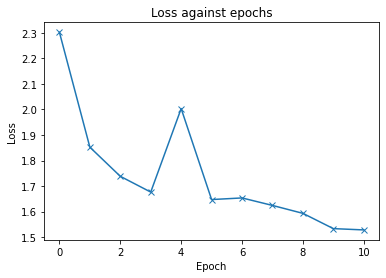

In [131]:
plot_losses(history)

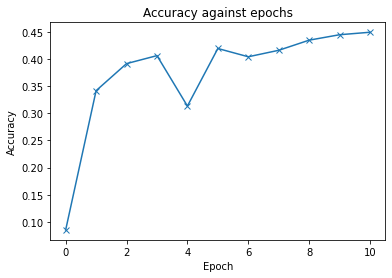

In [132]:
plot_accuracies(history)

# Part 3: Evaluating Parameters

Running baseline model while varying number of epochs: 10, 25, 50

In [133]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3067424297332764, 'validation_accuracy': 0.09713924676179886}]
Epoch 0 | validation_loss: 1.8492 | validation_accuracy: 0.3364
Epoch 1 | validation_loss: 1.8448 | validation_accuracy: 0.3341
Epoch 2 | validation_loss: 1.7363 | validation_accuracy: 0.3833
Epoch 3 | validation_loss: 1.7300 | validation_accuracy: 0.3909
Epoch 4 | validation_loss: 1.6827 | validation_accuracy: 0.4075
Epoch 5 | validation_loss: 1.6713 | validation_accuracy: 0.4062
Epoch 6 | validation_loss: 1.6284 | validation_accuracy: 0.4129
Epoch 7 | validation_loss: 1.5961 | validation_accuracy: 0.4328
Epoch 8 | validation_loss: 1.6622 | validation_accuracy: 0.4173
Epoch 9 | validation_loss: 1.5293 | validation_accuracy: 0.4497


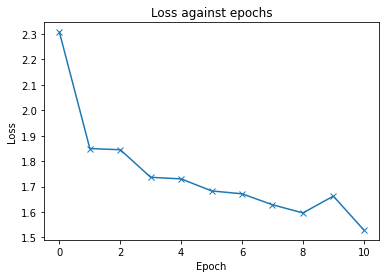

In [134]:
plot_losses(history)

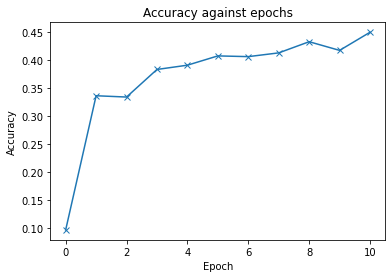

In [135]:
plot_accuracies(history)

In [136]:
epochs = 25
model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304063081741333, 'validation_accuracy': 0.10114888846874237}]
Epoch 0 | validation_loss: 2.0134 | validation_accuracy: 0.2623
Epoch 1 | validation_loss: 1.7798 | validation_accuracy: 0.3483
Epoch 2 | validation_loss: 1.8245 | validation_accuracy: 0.3658
Epoch 3 | validation_loss: 1.6598 | validation_accuracy: 0.4096
Epoch 4 | validation_loss: 1.6470 | validation_accuracy: 0.4094
Epoch 5 | validation_loss: 1.5725 | validation_accuracy: 0.4479
Epoch 6 | validation_loss: 1.5450 | validation_accuracy: 0.4461
Epoch 7 | validation_loss: 1.5336 | validation_accuracy: 0.4522
Epoch 8 | validation_loss: 1.6573 | validation_accuracy: 0.4167
Epoch 9 | validation_loss: 1.5914 | validation_accuracy: 0.4445
Epoch 10 | validation_loss: 1.5892 | validation_accuracy: 0.4415
Epoch 11 | validation_loss: 1.7238 | validation_accuracy: 0.4007
Epoch 12 | validation_loss: 1.5209 | validation_accuracy: 0.4665
Epoch 13 | validation_loss: 1.4681 | validation_accuracy: 0.4751
Epoch 14 | vali

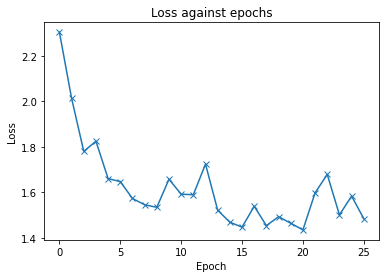

In [137]:
plot_losses(history)

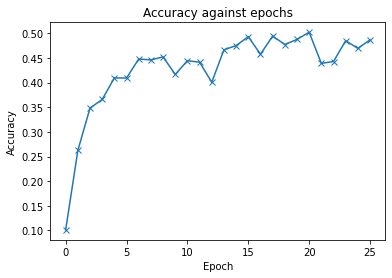

In [138]:
plot_accuracies(history)

In [139]:
epochs = 50
model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3001787662506104, 'validation_accuracy': 0.11143152415752411}]
Epoch 0 | validation_loss: 1.9021 | validation_accuracy: 0.3090
Epoch 1 | validation_loss: 1.7780 | validation_accuracy: 0.3585
Epoch 2 | validation_loss: 1.7256 | validation_accuracy: 0.3882
Epoch 3 | validation_loss: 1.6934 | validation_accuracy: 0.3989
Epoch 4 | validation_loss: 1.5820 | validation_accuracy: 0.4314
Epoch 5 | validation_loss: 1.5944 | validation_accuracy: 0.4312
Epoch 6 | validation_loss: 1.8063 | validation_accuracy: 0.3657
Epoch 7 | validation_loss: 1.6538 | validation_accuracy: 0.4138
Epoch 8 | validation_loss: 1.5181 | validation_accuracy: 0.4523
Epoch 9 | validation_loss: 1.5831 | validation_accuracy: 0.4295
Epoch 10 | validation_loss: 1.5267 | validation_accuracy: 0.4576
Epoch 11 | validation_loss: 1.4614 | validation_accuracy: 0.4830
Epoch 12 | validation_loss: 1.5065 | validation_accuracy: 0.4585
Epoch 13 | validation_loss: 1.4789 | validation_accuracy: 0.4765
Epoch 14 | val

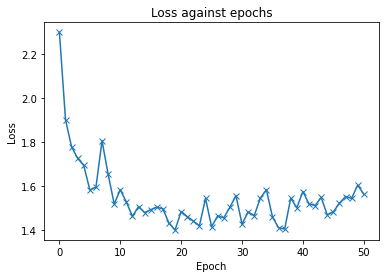

In [140]:
plot_losses(history)

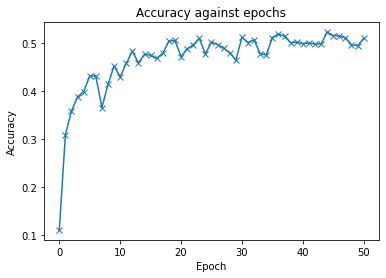

In [141]:
plot_accuracies(history)

Varying batch size: 64, 128, 256

In [142]:
# Baseline: 128

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

In [143]:
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.306427001953125, 'validation_accuracy': 0.09589843451976776}]
Epoch 0 | validation_loss: 1.8269 | validation_accuracy: 0.3472
Epoch 1 | validation_loss: 1.8721 | validation_accuracy: 0.3301
Epoch 2 | validation_loss: 1.7654 | validation_accuracy: 0.3794
Epoch 3 | validation_loss: 1.6272 | validation_accuracy: 0.4211
Epoch 4 | validation_loss: 1.6335 | validation_accuracy: 0.4276
Epoch 5 | validation_loss: 1.6504 | validation_accuracy: 0.4188
Epoch 6 | validation_loss: 1.5976 | validation_accuracy: 0.4300
Epoch 7 | validation_loss: 1.6469 | validation_accuracy: 0.4243
Epoch 8 | validation_loss: 1.5364 | validation_accuracy: 0.4552
Epoch 9 | validation_loss: 1.6270 | validation_accuracy: 0.4434


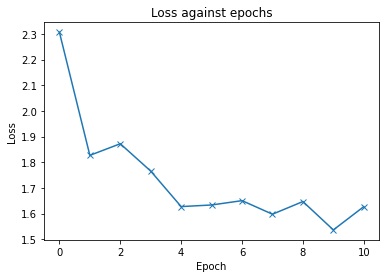

In [144]:
plot_losses(history)

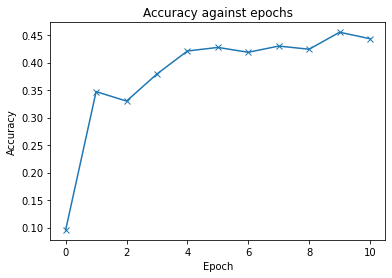

In [145]:
plot_accuracies(history)

In [146]:
# Lower: 64

batch_size = 64

training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.305133104324341, 'validation_accuracy': 0.10292968899011612}]
Epoch 0 | validation_loss: 1.9419 | validation_accuracy: 0.2719
Epoch 1 | validation_loss: 2.1272 | validation_accuracy: 0.2525
Epoch 2 | validation_loss: 1.8166 | validation_accuracy: 0.3570
Epoch 3 | validation_loss: 2.0121 | validation_accuracy: 0.3352
Epoch 4 | validation_loss: 1.9886 | validation_accuracy: 0.3291
Epoch 5 | validation_loss: 4.0064 | validation_accuracy: 0.1709
Epoch 6 | validation_loss: 1.7825 | validation_accuracy: 0.3762
Epoch 7 | validation_loss: 2.1143 | validation_accuracy: 0.3191
Epoch 8 | validation_loss: 2.3402 | validation_accuracy: 0.2998
Epoch 9 | validation_loss: 1.7443 | validation_accuracy: 0.4164


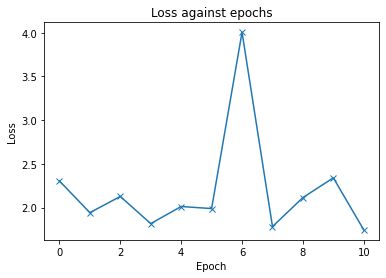

In [147]:
plot_losses(history)

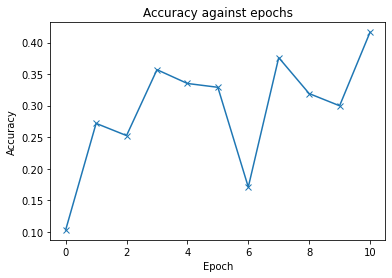

In [148]:
plot_accuracies(history)

In [149]:
# Higher: 256

batch_size = 256

training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304985523223877, 'validation_accuracy': 0.1101243644952774}]
Epoch 0 | validation_loss: 1.9136 | validation_accuracy: 0.3163
Epoch 1 | validation_loss: 1.7998 | validation_accuracy: 0.3570
Epoch 2 | validation_loss: 1.8215 | validation_accuracy: 0.3494
Epoch 3 | validation_loss: 1.8165 | validation_accuracy: 0.3415
Epoch 4 | validation_loss: 1.6644 | validation_accuracy: 0.4051
Epoch 5 | validation_loss: 1.7244 | validation_accuracy: 0.3830
Epoch 6 | validation_loss: 1.6369 | validation_accuracy: 0.4265
Epoch 7 | validation_loss: 1.5750 | validation_accuracy: 0.4491
Epoch 8 | validation_loss: 1.6652 | validation_accuracy: 0.4142
Epoch 9 | validation_loss: 1.5096 | validation_accuracy: 0.4680


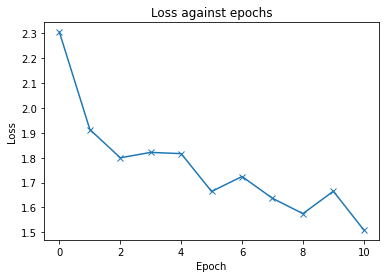

In [150]:
plot_losses(history)

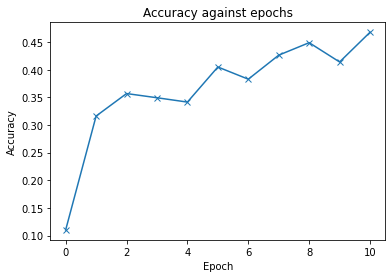

In [151]:
plot_accuracies(history)

Varying optimisation function: Stochastic Gradient Descent vs Adam

In [152]:
# Baseline: SGD

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304011344909668, 'validation_accuracy': 0.08251754194498062}]
Epoch 0 | validation_loss: 2.0074 | validation_accuracy: 0.2977
Epoch 1 | validation_loss: 1.9168 | validation_accuracy: 0.3045
Epoch 2 | validation_loss: 1.8114 | validation_accuracy: 0.3533
Epoch 3 | validation_loss: 1.8027 | validation_accuracy: 0.3605
Epoch 4 | validation_loss: 1.6416 | validation_accuracy: 0.4160
Epoch 5 | validation_loss: 1.8664 | validation_accuracy: 0.3469
Epoch 6 | validation_loss: 1.6305 | validation_accuracy: 0.4315
Epoch 7 | validation_loss: 1.6575 | validation_accuracy: 0.4130
Epoch 8 | validation_loss: 1.5654 | validation_accuracy: 0.4401
Epoch 9 | validation_loss: 1.5679 | validation_accuracy: 0.4424


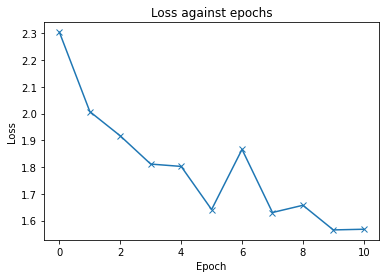

In [153]:
plot_losses(history)

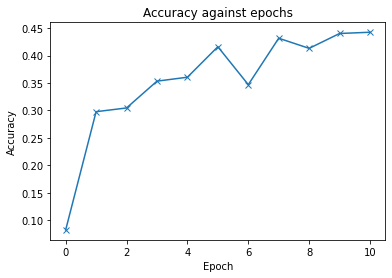

In [154]:
plot_accuracies(history)

In [155]:
# Alternative optimiser function: Adam

optimiser_function = torch.optim.Adam

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.306555986404419, 'validation_accuracy': 0.08655931055545807}]
Epoch 0 | validation_loss: 2.3085 | validation_accuracy: 0.0984
Epoch 1 | validation_loss: 2.3083 | validation_accuracy: 0.1005
Epoch 2 | validation_loss: 2.3109 | validation_accuracy: 0.0934
Epoch 3 | validation_loss: 2.3106 | validation_accuracy: 0.1007
Epoch 4 | validation_loss: 2.3083 | validation_accuracy: 0.1108
Epoch 5 | validation_loss: 2.3134 | validation_accuracy: 0.0922
Epoch 6 | validation_loss: 2.3088 | validation_accuracy: 0.1014
Epoch 7 | validation_loss: 2.3108 | validation_accuracy: 0.0930
Epoch 8 | validation_loss: 2.3104 | validation_accuracy: 0.0897
Epoch 9 | validation_loss: 2.3168 | validation_accuracy: 0.1008


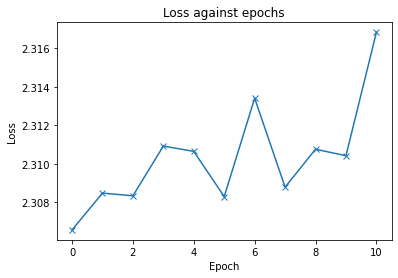

In [156]:
plot_losses(history)

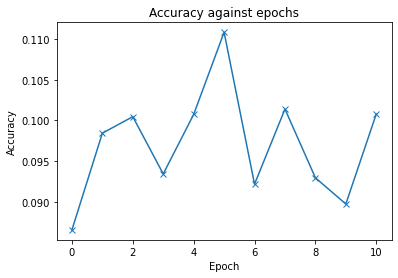

In [157]:
plot_accuracies(history)

Varying learning rate: 0.1, 0.01, 0.001

In [158]:
# Baseline: 0.1

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.307126522064209, 'validation_accuracy': 0.09537627547979355}]
Epoch 0 | validation_loss: 1.9295 | validation_accuracy: 0.3096
Epoch 1 | validation_loss: 1.9419 | validation_accuracy: 0.2852
Epoch 2 | validation_loss: 1.7386 | validation_accuracy: 0.3916
Epoch 3 | validation_loss: 1.7423 | validation_accuracy: 0.3802
Epoch 4 | validation_loss: 1.8133 | validation_accuracy: 0.3576
Epoch 5 | validation_loss: 1.6565 | validation_accuracy: 0.4133
Epoch 6 | validation_loss: 1.6470 | validation_accuracy: 0.4176
Epoch 7 | validation_loss: 1.6042 | validation_accuracy: 0.4299
Epoch 8 | validation_loss: 1.5458 | validation_accuracy: 0.4526
Epoch 9 | validation_loss: 1.5736 | validation_accuracy: 0.4493


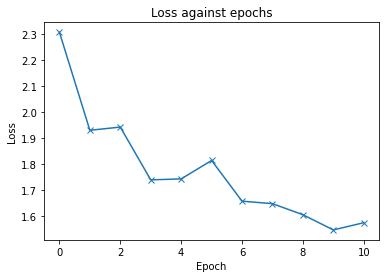

In [159]:
plot_losses(history)

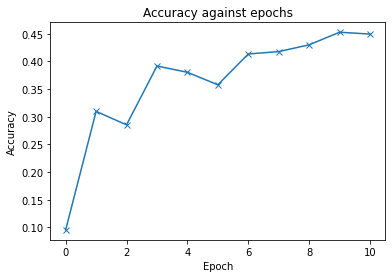

In [160]:
plot_accuracies(history)

In [161]:
# 0.01

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.01 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.302257537841797, 'validation_accuracy': 0.10167012363672256}]
Epoch 0 | validation_loss: 2.2323 | validation_accuracy: 0.1602
Epoch 1 | validation_loss: 2.1223 | validation_accuracy: 0.2514
Epoch 2 | validation_loss: 2.0379 | validation_accuracy: 0.2703
Epoch 3 | validation_loss: 1.9835 | validation_accuracy: 0.2974
Epoch 4 | validation_loss: 1.9443 | validation_accuracy: 0.3119
Epoch 5 | validation_loss: 1.9165 | validation_accuracy: 0.3264
Epoch 6 | validation_loss: 1.8935 | validation_accuracy: 0.3377
Epoch 7 | validation_loss: 1.8745 | validation_accuracy: 0.3462
Epoch 8 | validation_loss: 1.8528 | validation_accuracy: 0.3486
Epoch 9 | validation_loss: 1.8332 | validation_accuracy: 0.3549


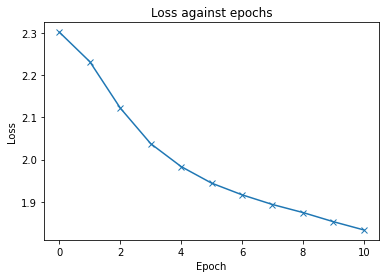

In [162]:
plot_losses(history)

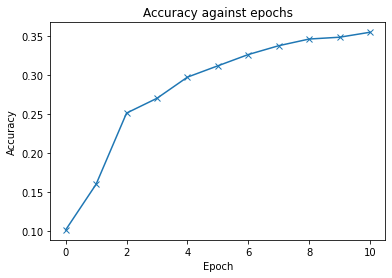

In [163]:
plot_accuracies(history)

In [164]:
# 0.001

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3071818351745605, 'validation_accuracy': 0.11262357234954834}]
Epoch 0 | validation_loss: 1.9507 | validation_accuracy: 0.2859
Epoch 1 | validation_loss: 1.8215 | validation_accuracy: 0.3523
Epoch 2 | validation_loss: 1.7668 | validation_accuracy: 0.3782
Epoch 3 | validation_loss: 1.7712 | validation_accuracy: 0.3684
Epoch 4 | validation_loss: 1.6684 | validation_accuracy: 0.4057
Epoch 5 | validation_loss: 1.6826 | validation_accuracy: 0.3995
Epoch 6 | validation_loss: 1.5800 | validation_accuracy: 0.4443
Epoch 7 | validation_loss: 1.6542 | validation_accuracy: 0.4125
Epoch 8 | validation_loss: 1.6276 | validation_accuracy: 0.4284
Epoch 9 | validation_loss: 1.6607 | validation_accuracy: 0.4140


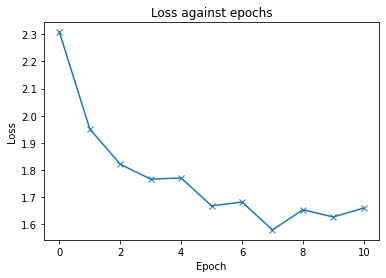

In [165]:
plot_losses(history)

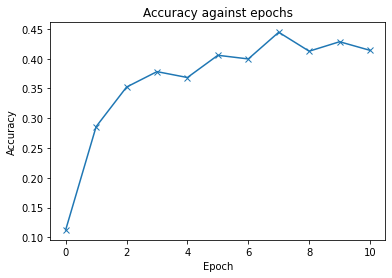

In [166]:
plot_accuracies(history)

Varying number of hidden layers: Baseline (one hidden), two hidden, three hidden

In [167]:
# Baseline - One hidden

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3076751232147217, 'validation_accuracy': 0.08953284472227097}]
Epoch 0 | validation_loss: 1.9651 | validation_accuracy: 0.2760
Epoch 1 | validation_loss: 1.8482 | validation_accuracy: 0.3451
Epoch 2 | validation_loss: 1.7990 | validation_accuracy: 0.3632
Epoch 3 | validation_loss: 1.7717 | validation_accuracy: 0.3727
Epoch 4 | validation_loss: 1.7157 | validation_accuracy: 0.3863
Epoch 5 | validation_loss: 1.6172 | validation_accuracy: 0.4329
Epoch 6 | validation_loss: 1.6782 | validation_accuracy: 0.4104
Epoch 7 | validation_loss: 1.6288 | validation_accuracy: 0.4134
Epoch 8 | validation_loss: 1.6487 | validation_accuracy: 0.4126
Epoch 9 | validation_loss: 1.6762 | validation_accuracy: 0.3982


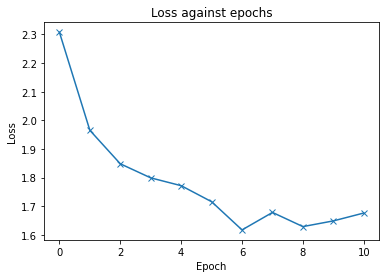

In [168]:
plot_losses(history)

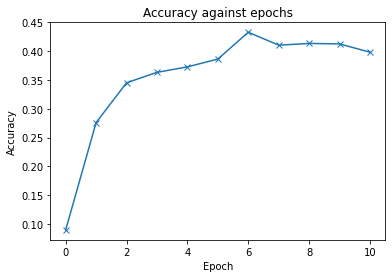

In [169]:
plot_accuracies(history)

In [170]:
# Two hidden layers

In [173]:
class Model_two_hidden(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        
        return x

In [174]:
model = move_to_device(Model_two_hidden(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3033862113952637, 'validation_accuracy': 0.1088687926530838}]
Epoch 0 | validation_loss: 1.9962 | validation_accuracy: 0.2761
Epoch 1 | validation_loss: 1.9046 | validation_accuracy: 0.3013
Epoch 2 | validation_loss: 1.8240 | validation_accuracy: 0.3475
Epoch 3 | validation_loss: 1.7449 | validation_accuracy: 0.3739
Epoch 4 | validation_loss: 1.8551 | validation_accuracy: 0.3143
Epoch 5 | validation_loss: 1.7246 | validation_accuracy: 0.3831
Epoch 6 | validation_loss: 1.7069 | validation_accuracy: 0.4021


KeyboardInterrupt: ignored

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
class Model_three_hidden(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 128)
        self.linear5 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
model = move_to_device(Model_three_hidden(), device) 

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

Varying number of nodes in hidden layers

In [ ]:
# Baseline

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
# Fewer nodes

In [ ]:
class Model_fewer_nodes(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
model = move_to_device(Model_fewer_nodes(), device) 

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
# More nodes

In [ ]:
class Model_more_nodes(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
model = move_to_device(Model_more_nodes(), device) 

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

# Final Model

Combining the best performing parameters

In [175]:
# Final parameters
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading
weight_decay = 1e-4 # L2 Regularisation parameter

In [176]:
training_loader = DeviceDataLoader(training_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

In [182]:
class Model_Final(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256) # Input layer
        self.linear2 = nn.Linear(256, 256) # Hidden layer
        self.linear3 = nn.Linear(256, 128) # Hidden layer
        self.linear4 = nn.Linear(128, output_size) # Output layer
        self.dropout = nn.Dropout(0.15) # Dropout layer: probability set to 0.25
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & relu functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.dropout(x) # Applying dropout
        x = self.linear4(x)
        
        return x

In [183]:
model = move_to_device(Model_Final(), device)

In [184]:
history = [validate_model(model, validation_loader)]
print(history)

[{'validation_loss': 2.304945468902588, 'validation_accuracy': 0.09874441474676132}]


In [185]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 2.0699 | validation_accuracy: 0.2289
Epoch 1 | validation_loss: 1.9275 | validation_accuracy: 0.2992
Epoch 2 | validation_loss: 1.8042 | validation_accuracy: 0.3481
Epoch 3 | validation_loss: 1.8778 | validation_accuracy: 0.3039
Epoch 4 | validation_loss: 1.7251 | validation_accuracy: 0.3769
Epoch 5 | validation_loss: 1.8788 | validation_accuracy: 0.3223
Epoch 6 | validation_loss: 1.6384 | validation_accuracy: 0.4133
Epoch 7 | validation_loss: 1.6427 | validation_accuracy: 0.4111
Epoch 8 | validation_loss: 1.6122 | validation_accuracy: 0.4261
Epoch 9 | validation_loss: 1.6090 | validation_accuracy: 0.4248


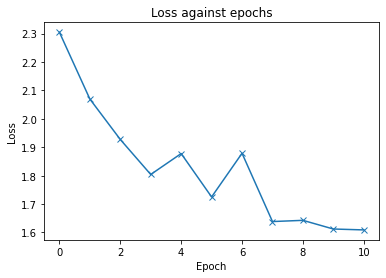

In [186]:
plot_losses(history)

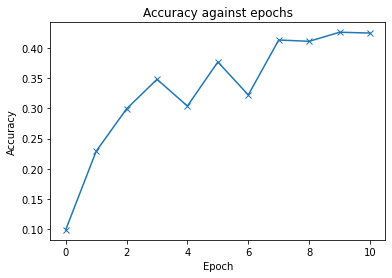

In [187]:
plot_accuracies(history)

In [188]:
learning_rate = 0.01 #Reducing learning rate
history += fit_model_L2(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function, weight_decay) # Applying L2 regularisation

Epoch 0 | validation_loss: 1.5375 | validation_accuracy: 0.4570
Epoch 1 | validation_loss: 1.5291 | validation_accuracy: 0.4596
Epoch 2 | validation_loss: 1.5269 | validation_accuracy: 0.4578
Epoch 3 | validation_loss: 1.5246 | validation_accuracy: 0.4595
Epoch 4 | validation_loss: 1.5184 | validation_accuracy: 0.4587
Epoch 5 | validation_loss: 1.5126 | validation_accuracy: 0.4576
Epoch 6 | validation_loss: 1.5035 | validation_accuracy: 0.4641
Epoch 7 | validation_loss: 1.5041 | validation_accuracy: 0.4670
Epoch 8 | validation_loss: 1.4977 | validation_accuracy: 0.4683
Epoch 9 | validation_loss: 1.4939 | validation_accuracy: 0.4687


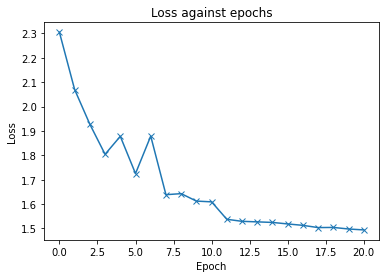

In [189]:
plot_losses(history)

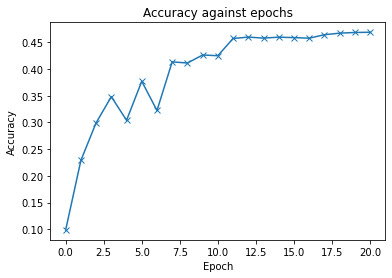

In [190]:
plot_accuracies(history)